In [1]:
try:
    from google.colab import drive  # type: ignore
    drive.mount('/content/drive')
    print('Mounted Google Drive.')
except ModuleNotFoundError:
    print('Running outside Google Colab; skipping Google Drive mount.')


Running outside Google Colab; skipping Google Drive mount.


In [2]:
from pathlib import Path
from PIL import Image, ImageSequence

PROJECT_ROOT = Path.cwd()
action_dataset_dir = PROJECT_ROOT / "Datasets" / "Action dataset"
frames_root = action_dataset_dir / "frames"
frames_root.mkdir(parents=True, exist_ok=True)


def save_frames_from_gif(gif_path: Path, action_label: str) -> None:
    """Extract RGB frames from a GIF into the dataset's frames directory."""
    action_dir = frames_root / action_label
    action_dir.mkdir(parents=True, exist_ok=True)

    img = Image.open(gif_path)
    for idx, frame in enumerate(ImageSequence.Iterator(img), start=1):
        frame_rgb = frame.convert("RGB")
        frame_filename = f"{action_label}_frame_{idx:04d}.jpg"
        frame_path = action_dir / frame_filename
        frame_rgb.save(frame_path)
        print(f"Saved: {frame_path}")


GIF_LABEL_OVERRIDES = {
    "sitting": "sit",
}

gif_files = sorted(action_dataset_dir.glob("*.gif"))
actions = []

for gif_path in gif_files:
    action_label = GIF_LABEL_OVERRIDES.get(gif_path.stem, gif_path.stem)
    actions.append(action_label)
    save_frames_from_gif(gif_path, action_label)

print("All frames extracted and saved successfully.")

print("\nImage Counts in Each Folder:")
for action_label in sorted(set(actions)):
    action_dir = frames_root / action_label
    num_images = len([img_path for img_path in action_dir.glob("*.jpg")])
    print(f"{action_label}: {num_images} images")


Saved: /home/mahin/Documents/notebook/Image-Analysis-on-Edge-Devices-for-Daycare-Application/Datasets/Action dataset/frames/kick/kick_frame_0001.jpg
Saved: /home/mahin/Documents/notebook/Image-Analysis-on-Edge-Devices-for-Daycare-Application/Datasets/Action dataset/frames/kick/kick_frame_0002.jpg
Saved: /home/mahin/Documents/notebook/Image-Analysis-on-Edge-Devices-for-Daycare-Application/Datasets/Action dataset/frames/kick/kick_frame_0003.jpg
Saved: /home/mahin/Documents/notebook/Image-Analysis-on-Edge-Devices-for-Daycare-Application/Datasets/Action dataset/frames/kick/kick_frame_0004.jpg
Saved: /home/mahin/Documents/notebook/Image-Analysis-on-Edge-Devices-for-Daycare-Application/Datasets/Action dataset/frames/kick/kick_frame_0005.jpg
Saved: /home/mahin/Documents/notebook/Image-Analysis-on-Edge-Devices-for-Daycare-Application/Datasets/Action dataset/frames/kick/kick_frame_0006.jpg
Saved: /home/mahin/Documents/notebook/Image-Analysis-on-Edge-Devices-for-Daycare-Application/Datasets/Acti

In [3]:
!pip install --upgrade tensorflow tensorflow_hub


  Using cached tensorflow-2.20.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.5 kB)
  Using cached tensorflow-2.20.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.5 kB)
  Using cached protobuf-6.32.1-cp39-abi3-manylinux2014_x86_64.whl.metadata (593 bytes)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached protobuf-6.32.1-cp39-abi3-manylinux2014_x86_64.whl.metadata (593 bytes)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)


In [5]:
from pathlib import Path

import numpy as np
from PIL import Image
import tensorflow as tf
import tensorflow_hub as hub

PROJECT_ROOT = Path.cwd()
action_dataset_dir = PROJECT_ROOT / "Datasets" / "Action dataset"
frames_root = action_dataset_dir / "frames"
keypoints_dir = action_dataset_dir / "pose_keypoints"
keypoints_dir.mkdir(parents=True, exist_ok=True)

movenet_module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
movenet = movenet_module.signatures["serving_default"]

SUPPORTED_EXTENSIONS = {".png", ".jpg", ".jpeg"}

def detect_pose(image: Image.Image) -> np.ndarray:
    """Run MoveNet to detect pose keypoints for a single RGB image."""
    image_np = np.array(image)
    input_image = tf.image.resize_with_pad(image_np, 192, 192)
    input_image = tf.expand_dims(input_image, axis=0)
    input_image = tf.cast(input_image, dtype=tf.int32)

    outputs = movenet(input_image)
    keypoints = outputs["output_0"].numpy().squeeze()
    return keypoints[:, :3]

def save_keypoints_for_action(action_folder: Path, action_label: str) -> None:
    """Extract pose keypoints for every frame in a given action folder."""
    frame_paths = sorted(
        path for path in action_folder.iterdir() if path.suffix.lower() in SUPPORTED_EXTENSIONS
    )
    if not frame_paths:
        print(f"No frames found for action '{action_label}'. Skipping.")
        return

    keypoints_data = []
    for image_path in frame_paths:
        frame = Image.open(image_path).convert("RGB")
        keypoints = detect_pose(frame)
        keypoints_data.append(keypoints.tolist())

    data = {
        "label": action_label,
        "keypoints": keypoints_data,
    }

    json_path = keypoints_dir / f"{action_label}_keypoints.json"
    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(data, f)
    print(f"Saved keypoints: {json_path}")

target_actions = ["kick", "punch", "running", "squat", "stand", "wave", "sit", "fall"]
available_actions = [label for label in target_actions if (frames_root / label).exists()]

missing_actions = sorted(set(target_actions) - set(available_actions))
if missing_actions:
    print(f"Skipping missing action folders: {missing_actions}")

for action_label in available_actions:
    action_folder = frames_root / action_label
    save_keypoints_for_action(action_folder, action_label)

print("Keypoint extraction completed for all available actions.")


I0000 00:00:1759242904.547391 1566055 cuda_dnn.cc:529] Loaded cuDNN version 91002


Saved keypoints: /home/mahin/Documents/notebook/Image-Analysis-on-Edge-Devices-for-Daycare-Application/Datasets/Action dataset/pose_keypoints/kick_keypoints.json
Saved keypoints: /home/mahin/Documents/notebook/Image-Analysis-on-Edge-Devices-for-Daycare-Application/Datasets/Action dataset/pose_keypoints/punch_keypoints.json
Saved keypoints: /home/mahin/Documents/notebook/Image-Analysis-on-Edge-Devices-for-Daycare-Application/Datasets/Action dataset/pose_keypoints/punch_keypoints.json
Saved keypoints: /home/mahin/Documents/notebook/Image-Analysis-on-Edge-Devices-for-Daycare-Application/Datasets/Action dataset/pose_keypoints/running_keypoints.json
Saved keypoints: /home/mahin/Documents/notebook/Image-Analysis-on-Edge-Devices-for-Daycare-Application/Datasets/Action dataset/pose_keypoints/running_keypoints.json
Saved keypoints: /home/mahin/Documents/notebook/Image-Analysis-on-Edge-Devices-for-Daycare-Application/Datasets/Action dataset/pose_keypoints/squat_keypoints.json
Saved keypoints: /h

In [7]:
import os
import json
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Function to create subsequences from a sequence
def create_subsequences(sequence, window_size, step_size):
    subsequences = []
    for start in range(0, len(sequence) - window_size + 1, step_size):
        end = start + window_size
        subsequences.append(sequence[start:end])
    return subsequences

# Load keypoints from JSON files and create subsequences
def load_keypoints(keypoints_dir, window_size=30, step_size=5):
    X = []
    y = []
    for filename in os.listdir(keypoints_dir):
        if filename.endswith('.json'):
            filepath = os.path.join(keypoints_dir, filename)
            with open(filepath, 'r') as f:
                data = json.load(f)
                keypoints = data['keypoints']
                label = data['label']

                # Flatten the keypoints for each frame
                flattened_keypoints = [np.array(kp).flatten() for kp in keypoints]

                # Create subsequences
                subsequences = create_subsequences(flattened_keypoints, window_size, step_size)
                X.extend(subsequences)
                y.extend([label] * len(subsequences))

    # Convert X and y to arrays
    X = np.array(X)
    y = np.array(y)

    return X, y

# Load keypoints data
X, y = load_keypoints(keypoints_dir)

# Convert labels to numerical values
actions = ['kick', 'punch', 'squat', 'stand', 'wave', 'running', 'sit', 'fall']
action_map = {action: i for i, action in enumerate(actions)}
y_numeric = np.array([action_map[label] for label in y])

# One-hot encode the labels
y_encoded = to_categorical(y_numeric, num_classes=len(actions))

# Split the data into training and test sets using stratified sampling
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_numeric
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (1537, 30, 51)
y_train shape: (1537, 8)
X_test shape: (385, 30, 51)
y_test shape: (385, 8)


In [9]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
    layers.Masking(mask_value=0.0),
    layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.3)),
    layers.Bidirectional(layers.LSTM(64, dropout=0.3)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(actions), activation='softmax'),
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 30, 51)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 30, 256)        │       184,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 357,448 (1.36 MB)

 Trainable params: 357,448 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Save the trained model locally within the repository structure
model_path = action_dataset_dir / "action_recognition_model.h5"
model.save(model_path)
print(f"Model saved to {model_path}")


Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.2251 - loss: 1.9970 - val_accuracy: 0.3792 - val_loss: 1.8855
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.2251 - loss: 1.9970 - val_accuracy: 0.3792 - val_loss: 1.8855
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3025 - loss: 1.8922 - val_accuracy: 0.4779 - val_loss: 1.7008
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3025 - loss: 1.8922 - val_accuracy: 0.4779 - val_loss: 1.7008
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3754 - loss: 1.7541 - val_accuracy: 0.3792 - val_loss: 1.5119
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3754 - loss: 1.7541 - val_accuracy: 0.3792 - val_loss: 1.5119
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3845 - loss: 1.6415 - val_accuracy: 0.3974 - val_loss: 1.3824
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3845 - loss: 1.6415 - val_accuracy: 0.3974 - v

Model saved to /home/mahin/Documents/notebook/Image-Analysis-on-Edge-Devices-for-Daycare-Application/Datasets/Action dataset/action_recognition_model.h5


In [11]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict the action for a new sequence of keypoints
new_keypoints = X_test[0].reshape(1, X_test.shape[1], X_test.shape[2])
predicted_action = model.predict(new_keypoints)
predicted_label = actions[np.argmax(predicted_action)]
print(f"Predicted Action: {predicted_label}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9662 - loss: 0.3648 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9662 - loss: 0.3648 
Test Accuracy: 0.9662
Test Accuracy: 0.9662
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
Predicted Action: wave
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
Predicted Action: wave


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


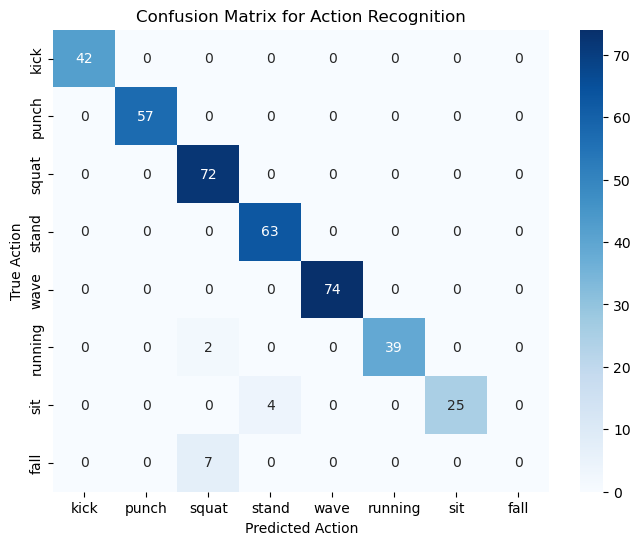

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict actions for all test data
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=actions, yticklabels=actions)
plt.xlabel('Predicted Action')
plt.ylabel('True Action')
plt.title('Confusion Matrix for Action Recognition')
plt.show()


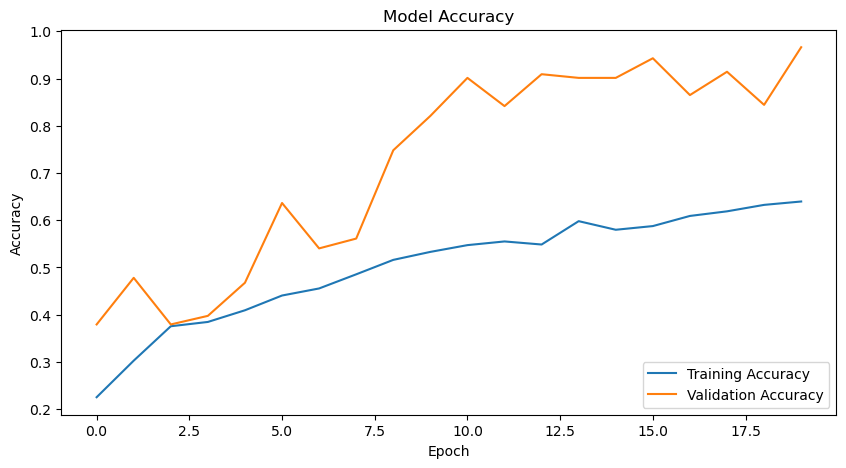

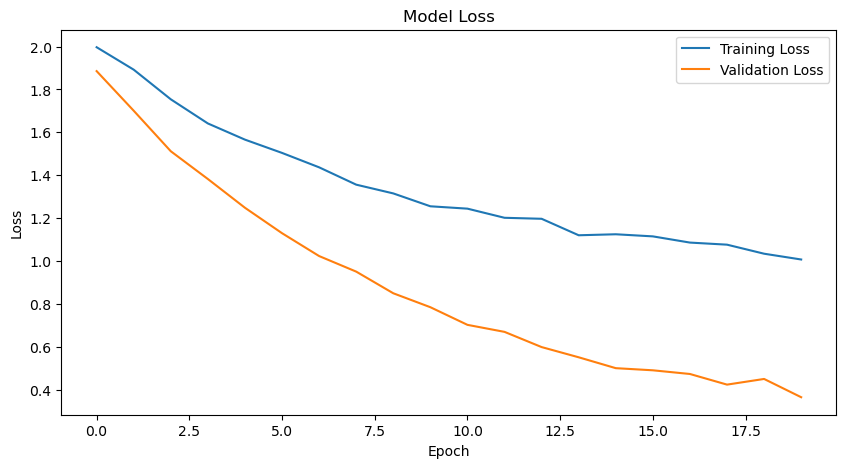

In [13]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')  # Place legend in the lower right corner
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')  # Place legend in the upper right corner
plt.show()


In [15]:
import numpy as np
from tensorflow.keras.models import load_model
from PIL import Image
import tensorflow_hub as hub

# Load the trained model stored alongside the dataset
model_path = action_dataset_dir / "action_recognition_model.h5"
model = load_model(model_path)

# Reuse MoveNet to extract pose keypoints (matching the training pipeline)
movenet_module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
movenet = movenet_module.signatures["serving_default"]


def detect_pose(image: np.ndarray) -> np.ndarray:
    """Detect pose keypoints and return (17, 3) array of y, x, score."""
    input_image = tf.image.resize_with_pad(tf.expand_dims(image, axis=0), 192, 192)
    input_image = tf.cast(input_image, dtype=tf.int32)
    keypoints_with_scores = movenet(input_image)
    keypoints = keypoints_with_scores["output_0"].numpy()[0, 0, :, :3]
    return keypoints


# Load and preprocess a test image from the local dataset
default_image_path = frames_root / "running" / "running_frame_0001.jpg"
if not default_image_path.exists():
    raise FileNotFoundError(
        "No sample image found at the expected location. Update `default_image_path` with an existing frame."
    )

image = Image.open(default_image_path).convert("RGB")
image_np = np.array(image)

# Detect keypoints and format them for the LSTM model
keypoints = detect_pose(image_np)
flattened_keypoints = keypoints.flatten().astype(np.float32)
window_size = X_train.shape[1]
sequence = np.tile(flattened_keypoints[None, :], (window_size, 1))
sequence = np.expand_dims(sequence, axis=0)  # Shape: (1, window_size, num_features)

# Predict the action
predictions = model.predict(sequence)
predicted_class = np.argmax(predictions)

action_labels = ['kick', 'punch', 'squat', 'stand', 'wave', 'running', 'sit', 'fall']
predicted_label = action_labels[predicted_class]

print(f"Predicted action: {predicted_label} (confidence {predictions[0][predicted_class]:.2%})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
Predicted action: running (confidence 59.29%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
Predicted action: running (confidence 59.29%)


In [16]:
# Install MediaPipe if not already installed
!pip install mediapipe

# Import necessary libraries
import cv2
import numpy as np
import mediapipe as mp
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline


I0000 00:00:1759244287.874311 1542819 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1759244287.913646 1624209 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.247.01), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1759244287.972544 1624180 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1759244288.006509 1624194 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1759244288.031838 1624181 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


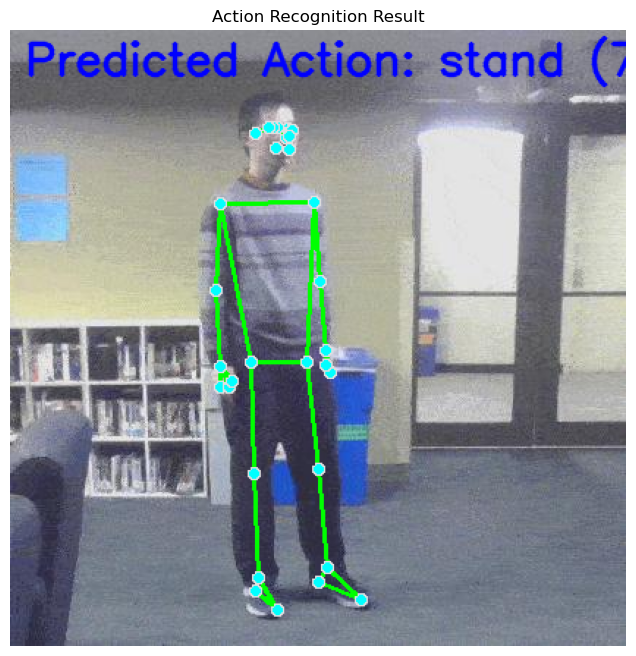

In [19]:
import cv2
import numpy as np
import mediapipe as mp
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from PIL import Image

# Choose a sample frame from the local dataset
default_action = "stand"
available_frames = sorted((frames_root / default_action).glob("*.jpg"))
default_frame = next(iter(available_frames), None)
if default_frame is None:
    raise FileNotFoundError(
        "No sample frame found in the expected directory. Please update `default_action` or add frames." 
    )

image = cv2.imread(str(default_frame))
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Initialize MediaPipe Pose for visualization
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)

# Process the image and extract keypoints for visualization
results = pose.process(image_rgb)
image_with_keypoints = image_rgb.copy()

if not results.pose_landmarks:
    print("No pose landmarks detected by MediaPipe; defaulting to zeros for visualization.")
else:
    mp_drawing.draw_landmarks(
        image_with_keypoints,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 255), thickness=2, circle_radius=2),
        connection_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2),
    )

pose.close()

# Use the MoveNet-based detector from earlier cells to keep features consistent with training
if "detect_pose" not in globals():
    raise RuntimeError("`detect_pose` function is not defined. Please run the keypoint extraction cell first.")

keypoints = detect_pose(Image.fromarray(image_rgb))
flattened_keypoints = keypoints.flatten().astype(np.float32)

window_size = X_train.shape[1]
num_features = X_train.shape[2]
if flattened_keypoints.size != num_features:
    raise ValueError(
        f"Expected {num_features} features, but got {flattened_keypoints.size}. Ensure the detector matches the training data."
    )

sequence = np.tile(flattened_keypoints, (window_size, 1))
sequence = np.expand_dims(sequence, axis=0)

# Load the trained model
model_path = action_dataset_dir / "action_recognition_model.h5"
model = load_model(model_path)

# Predict the action
prediction = model.predict(sequence)
predicted_action_index = int(np.argmax(prediction[0]))
confidence_score = float(prediction[0][predicted_action_index])

# Use the same action labels defined earlier
action_labels = actions
predicted_action = action_labels[predicted_action_index]

# Prepare annotation text
font = cv2.FONT_HERSHEY_SIMPLEX
position = (10, 30)
font_scale = 1
font_color = (255, 0, 0)
thickness = 2
text = f"Predicted Action: {predicted_action} ({confidence_score * 100:.2f}%)"

image_with_keypoints_bgr = cv2.cvtColor(image_with_keypoints, cv2.COLOR_RGB2BGR)
cv2.putText(image_with_keypoints_bgr, text, position, font, font_scale, font_color, thickness, cv2.LINE_AA)
final_image = cv2.cvtColor(image_with_keypoints_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 8))
plt.imshow(final_image)
plt.axis('off')
plt.title('Action Recognition Result')
plt.show()
